In [1]:
# packages
import numpy as np 
import matplotlib.pyplot as plt
import os
from scipy import integrate
from scipy.stats import norm

import astropy.coordinates as coord
import astropy.units as u
from scipy import integrate, optimize
import pandas as pd
pd.set_option('display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import astropy.units as u




# graphic parameters
plt.rcParams['font.size'] = 19
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rcParams['axes.linewidth']  = 1.4
plt.rcParams['figure.figsize']  = (8, 4)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 1.8
plt.rcParams['ytick.major.width'] = 1.8   
plt.rcParams['lines.markeredgewidth'] = 2

# defining a numpy seed for random
np.random.seed(0)

# creating a folder to save the plots
pltpath = 'plots/'
if not os.path.exists(pltpath):
    os.makedirs(pltpath)
dpi      = 450     # resolution of saved images
formatIm = '.png'  # format of saved images

# ----- some constants ----- #
G     = 6.6743e-8     # gravitational constant
kb    = 1.3807e-16    # Boltzmann constant
sigma = 5.67e-5       # Stefan-Boltzmann constant
Msun  = 1.9884e33     # sun mass
Rsun  = 6.957e10      # sun radius
m_H   = 1.6726e-24    # mass of the proton/hydrogen
m_e   = 9.1094e-28    # mass of the electron
c     = 2.9979e10     # speed of light
Na    = 6.022140e22   # avogadro number
aRad  = 7.5657e-15    # radiation constant
hPl   = 6.6261e-27    # planck constant
ech   = 4.8032e-10    # electron charge
hbar  = 1.0546e-27

def wrap_to_pi(arr):
    return (arr + np.pi) % (2 * np.pi) - np.pi

In [2]:
from gammapy.catalog import SourceCatalog4FGL, SourceCatalog3FHL
from gammapy.catalog import SourceCatalogHGPS, SourceCatalogGammaCat

from gammapy.catalog import CATALOG_REGISTRY

from astropy.coordinates import SkyCoord, Angle

print(CATALOG_REGISTRY)

catalog_4fgl = SourceCatalog4FGL("/home/juan/gammapy-datasets/1.0.1/catalogs/fermi/gll_psc_v28.fit.gz")
print("Number of sources :", len(catalog_4fgl.table))

display(catalog_4fgl.table)

Registry
--------

SourceCatalogGammaCat: gamma-cat 
SourceCatalogHGPS    : hgps 
SourceCatalog2HWC    : 2hwc 
SourceCatalog3FGL    : 3fgl 
SourceCatalog4FGL    : 4fgl 
SourceCatalog2FHL    : 2fhl 
SourceCatalog3FHL    : 3fhl 
SourceCatalog3HWC    : 3hwc 

Number of sources : 6659


Source_Name,DataRelease,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Extended_Source_Name,Signif_Avg,Pivot_Energy,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,SpectrumType,PL_Flux_Density,Unc_PL_Flux_Density,PL_Index,Unc_PL_Index,LP_Flux_Density,Unc_LP_Flux_Density,LP_Index,Unc_LP_Index,LP_beta,Unc_LP_beta,LP_SigCurv,LP_EPeak,Unc_LP_EPeak,PLEC_Flux_Density,Unc_PLEC_Flux_Density,PLEC_IndexS,Unc_PLEC_IndexS,PLEC_ExpfactorS,Unc_PLEC_ExpfactorS,PLEC_Exp_Index,Unc_PLEC_Exp_Index,PLEC_SigCurv,PLEC_EPeak,Unc_PLEC_EPeak,Npred,Flux_Band,Unc_Flux_Band,nuFnu_Band,Sqrt_TS_Band,Variability_Index,Frac_Variability,Unc_Frac_Variability,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,Flux_History,Unc_Flux_History,Sqrt_TS_History,ASSOC_4FGL,ASSOC_FGL,ASSOC_FHL,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,CLASS2,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,RA_Counterpart,DEC_Counterpart,Unc_Counterpart,Flags
,,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,,,MeV,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),,1 / (cm2 MeV s),1 / (cm2 MeV s),,,1 / (cm2 MeV s),1 / (cm2 MeV s),,,,,,MeV,MeV,1 / (cm2 MeV s),1 / (cm2 MeV s),,,,,,,,MeV,MeV,,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,,,,,1 / (cm2 s),1 / (cm2 s),s,s,1 / (cm2 s),1 / (cm2 s),,,,,,,,,,,,,,,,deg,deg,deg,
bytes18,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bytes18,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[8],"float32[8,2]",float32[8],float32[8],float32,float32,float32,float32,float32,float32,float64,float32,float32[12],"float32[12,2]",float32[12],bytes18,bytes18,bytes18,bytes18,bytes18,bytes18,bytes1,bytes30,bytes5,bytes10,bytes28,bytes28,float32,float32,float64,float64,float32,int16
4FGL J0000.3-7355,1,0.0983,-73.9220,307.7090,-42.7295,0.0324,0.0315,-62.700,0.0525,0.0510,-62.700,1532,,7.460,2329.59,1.3922e-10,2.3621e-11,1.5811e-12,2.8112e-13,PowerLaw,2.6104e-14,4.4296e-15,2.1797,0.1357,2.9043e-14,6.1793e-15,2.0637,0.2425,0.0919,0.1389,0.749,1647.6,2851.5,2.9185e-14,5.6286e-15,1.9930,0.2373,0.15061,0.15734,0.6667,--,1.292,2438.5,3654.9,305.21,1.7739895e-08 .. 1.7826393e-16,-- .. 2.4431169e-12,2.8217517e-12 .. 2.9540846e-17,0.8570334 .. 0.0,14.6025,0.2158,0.4133,-inf,-inf,-inf,-inf,-inf,3.706403e-13 .. 1.7295249e-09,-- .. 1.0973934e-09,0.0 .. 2.6882997,4FGL J0000.3-7355,,,,,,N,,,,,,0.0000,0.0000,--,--,--,0
4FGL J0000.5+0743,2,0.1375,7.7273,101.6565,-53.0295,0.0945,0.0700,-10.220,0.1533,0.1135,-10.220,307,,5.272,1304.19,1.9519e-10,4.0855e-11,1.1219e-12,3.2927e-13,LogParabola,1.0399e-13,2.1858e-14,2.3497,0.1405,1.5756e-13,3.6368e-14,2.0696,0.3715,0.4544,0.2896,2.550,1208.1,491.2,1.4754e-13,3.3768e-14,1.9981,0.3109,0.58622,0.40205,0.6667,--,2.533,1308.4,691.0,197.24,1.1467303e-10 .. 4.9146895e-16,-- .. 3.2301143e-12,1.9877644e-14 .. 4.5535866e-17,0.0 .. 0.0,25.3995,0.6876,0.2849,5.156,3.136125e-09,7.956976e-10,507590016.0,31560000.0,6.128976e-10 .. 3.5567613e-13,-4.523282e-10 .. 6.355095e-10,1.4430193 .. 0.0,4FGL J0000.5+0743,,,,,,N,,,,,,0.0000,0.0000,--,--,--,0
4FGL J0000.7+2530,3,0.1878,25.5153,108.7751,-35.9592,0.0514,0.0410,82.400,0.0833,0.0665,82.400,623,,4.177,6318.94,7.2022e-11,2.5537e-11,8.5713e-13,2.7131e-13,PowerLaw,2.0581e-15,6.4946e-16,1.8528,0.2119,3.0438e-15,1.1653e-15,1.6462,0.4475,0.3764,0.3703,1.471,10111.1,6127.8,3.0795e-15,1.1731e-15,1.5078,0.5142,0.72024,0.68253,0.6667,--,1.563,11096.6,5117.6,87.71,1.5116805e-11 .. 3.004443e-13,-- .. 4.0086706e-12,2.4359283e-15 .. 5.683455e-14,0.0 .. 0.16206099,13.6505,0.0000,10.0000,-inf,-inf,-inf,-inf,-inf,1.4620708e-09 .. 2.8997136e-13,-6.50944e-10 .. 6.629278e-10,3.988602 .. 0.0,,,,,,,N,,,,,,0.0000,0.0000,--,--,--,0
4FGL J0001.2+4741,1,0.3126,47.6859,11

In [3]:
tbl = catalog_4fgl.table

namesDEL = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
df       = tbl[namesDEL].to_pandas()

for col in ['Source_Name', 'Extended_Source_Name', 'CLASS1', 'CLASS2']:
    df[col] = df[col].apply(lambda x: x.decode('utf-8'))
    
    
df['GLON'] = -df['GLON']
display(df.head(6))

,Source_Name,DataRelease,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Extended_Source_Name,Signif_Avg,Pivot_Energy,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,SpectrumType,PL_Flux_Density,Unc_PL_Flux_Density,PL_Index,Unc_PL_Index,LP_Flux_Density,Unc_LP_Flux_Density,LP_Index,Unc_LP_Index,LP_beta,Unc_LP_beta,LP_SigCurv,LP_EPeak,Unc_LP_EPeak,PLEC_Flux_Density,Unc_PLEC_Flux_Density,PLEC_IndexS,Unc_PLEC_IndexS,PLEC_ExpfactorS,Unc_PLEC_ExpfactorS,PLEC_Exp_Index,Unc_PLEC_Exp_Index,PLEC_SigCurv,PLEC_EPeak,Unc_PLEC_EPeak,Npred,Variability_Index,Frac_Variability,Unc_Frac_Variability,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,ASSOC_4FGL,ASSOC_FGL,ASSOC_FHL,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,CLASS2,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,RA_Counterpart,DEC_Counterpart,Unc_Counterpart,Flags
0,4FGL J0000.3-7355,1,0.0983,-73.921997,-307.708984,-42.729538,0.032378,0.031453,-62.700001,0.0525,0.0510,-62.700001,1532,,7.459561,2329.590332,1.392216e-10,2.362096e-11,1.581100e-12,2.811228e-13,b'PowerLaw ',2.610434e-14,4.429607e-15,2.179690,0.135742,2.904301e-14,6.179337e-15,2.063685,0.242461,0.091939,0.138896,0.749253,1647.642700,2851.525879,2.918480e-14,5.628575e-15,1.993013,0.237311,0.150609,0.157339,0.666667,NaN,1.292339,2438.500977,3654.853027,305.214630,14.602470,0.215777,0.413314,-inf,-inf,-inf,-inf,-inf,b'4FGL J0000.3-7355 ',b' ',b' ',b' ',b' ',b' ',b'N',b' ',,,b' ',b' ',0.000000,0.000000,NaN,NaN,NaN,0
1,4FGL J0000.5+0743,2,0.1375,7.727300,-101.656479,-53.029457,0.094544,0.069999,-10.220000,0.1533,0.1135,-10.220000,307,,5.271726,1304.194702,1.951913e-10,4.085454e-11,1.121896e-12,3.292749e-13,b'LogParabola ',1.039931e-13,2.185767e-14,2.349694,0.140494,1.575568e-13,3.636783e-14,2.069591,0.371520,0.454411,0.289610,2.549887,1208.057373,491.238129,1.475405e-13,3.376789e-14,1.998095,0.310854,0.586220,0.402050,0.666667,NaN,2.532814,1308.434570,691.023376,197.244095,25.399525,0.687574,0.284856,5.156346,3.136125e-09,7.956976e-10,507590016.0,31560000.0,b'4FGL J0000.5+0743 ',b' ',b' ',b' ',b' ',b' ',b'N',b' ',,,b' ',b' ',0.000000,0.000000,NaN,NaN,NaN,0
2,4FGL J0000.7+2530,3,0.1878,25.515301,-108.775070,-35.959175,0.051373,0.041012,82.400002,0.0833,0.0665,82.400002,623,,4.177483,6318.939941,7.202151e-11,2.553710e-11,8.571274e-13,2.713094e-13,b'PowerLaw ',2.058057e-15,6.494554e-16,1.852803,0.211903,3.043761e-15,1.165287e-15,1.646164,0.447546,0.376358,0.370307,1.471138,10111.068359,6127.807129,3.079466e-15,1.173057e-15,1.507830,0.514213,0.720244,0.682527,0.666667,NaN,1.562938,11096.569336,5117.606445,87.706520,13.650518,0.000000,10.000000,-inf,-inf,-inf,-inf,-inf,b' ',b' ',b' ',b' ',b' ',b' ',b'N',b' ',,,b' ',b' ',0.000000,0.000000,NaN,NaN,NaN,0
3,4FGL J0001.2+4741,1,0.3126,47.685902,-114.250198,-14.338059,0.036880,0.033180,-45.900002,0.0598,0.0538,-45.900002,860,,4.692600,2420.575195,1.259796e-10,2.877197e-11,1.499454e-12,3.968492e-13,b'PowerLaw ',2.156031e-14,4.906863e-15,2.271696,0.179057,2.196550e-14,6.115012e-15,2.254081,0.226351,0.012156,0.108880,0.083893,NaN,NaN,2.228697e-14,5.419623e-15,2.219642,0.229325,0.029462,0.091426,0.666667,NaN,0.337723,NaN,NaN,293.149780,25.313953,0.675882,0.312850,5.201714,8.072130e-09,2.148715e-09,286670016.0,31560000.0,b'4FGL J0001.2+4741 ',b' ',b' ',b' ',b' ',b' ',b'N',b' ',bcu,,b'B3 2358+474 ',b' ',0.996097,0.938563,0.329341,47.700201,8.400000e-07,0
4,4FGL J0001.2-0747,1,0.3151,-7.797100,-89.032722,-67.305008,0.018440,0.017577,64.099998,0.0299,0.0285,64.099998,933,,23.782486,1721.603882,7.471219e-10,5.041939e-11,8.339171e-12,5.499455e-13,b'PowerLaw ',2.656894e-13,1.741040e-14,2.116692,0.049792,2.842831e-13,2.173665e-14,2.078927,0.065974,0.051182,0.033735,1.697737,796.297852,766.797424,2.813444e-13,2.077029e-14,2.046604,0.070298,0.063212,0.042852,0.666667,NaN,1.892928,624.239502,1758.489624,1192.351929,46.780693,0.406565,0.111870,10.646099,1.772592e-08,2.242407e-09,3497900

In [4]:
crabname = '4FGL J0534.5+2201i'

df[df['Extended_Source_Name'].str.contains('a')]

,Source_Name,DataRelease,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Extended_Source_Name,Signif_Avg,Pivot_Energy,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,SpectrumType,PL_Flux_Density,Unc_PL_Flux_Density,PL_Index,Unc_PL_Index,LP_Flux_Density,Unc_LP_Flux_Density,LP_Index,Unc_LP_Index,LP_beta,Unc_LP_beta,LP_SigCurv,LP_EPeak,Unc_LP_EPeak,PLEC_Flux_Density,Unc_PLEC_Flux_Density,PLEC_IndexS,Unc_PLEC_IndexS,PLEC_ExpfactorS,Unc_PLEC_ExpfactorS,PLEC_Exp_Index,Unc_PLEC_Exp_Index,PLEC_SigCurv,PLEC_EPeak,Unc_PLEC_EPeak,Npred,Variability_Index,Frac_Variability,Unc_Frac_Variability,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,ASSOC_4FGL,ASSOC_FGL,ASSOC_FHL,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,CLASS2,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,RA_Counterpart,DEC_Counterpart,Unc_Counterpart,Flags
239,4FGL J0058.0-7245e,1,14.500000,-72.750000,-302.251465,-44.369579,NaN,NaN,NaN,NaN,NaN,NaN,913,SMC-Galaxy,34.192863,811.365234,2.953098e-09,1.130973e-10,2.676263e-11,1.045414e-12,b'PLSuperExpCutoff ',5.156383e-12,1.692785e-13,2.197480,0.021797,5.921063e-12,2.284225e-13,2.111252,0.033005,0.091928,0.017993,6.092444,443.018707,112.363922,5.566747e-12,2.011381e-13,2.075645,0.033501,0.061779,0.015920,1.000000,NaN,5.678818,NaN,NaN,5870.731934,18.010691,0.090214,0.047852,-inf,-inf,-inf,-inf,-inf,b'4FGL J0058.0-7245e',b'3FGL J0059.0-7242e',b' ',b' ',b' ',b' ',b'N',b' ',GAL,,b'SMC ',b' ',NaN,NaN,13.160000,-72.800003,1.05000,2
802,4FGL J0322.6-3712e,1,50.669998,-37.209999,-240.166656,-56.692905,NaN,NaN,NaN,NaN,NaN,NaN,1183,Fornax A,18.400103,1775.844238,5.589642e-10,4.148565e-11,6.209482e-12,4.630529e-13,b'PowerLaw ',1.824819e-13,1.314113e-14,2.053747,0.053236,1.931455e-13,1.635106e-14,2.022597,0.064751,0.035314,0.030877,1.218807,1289.594849,1362.541138,1.873908e-13,1.437040e-14,2.017580,0.066006,0.020689,0.022915,0.666667,NaN,1.048967,506.911285,4377.267090,988.587891,14.264258,0.154046,0.127279,-inf,-inf,-inf,-inf,-inf,b'4FGL J0322.6-3712e',b'3FGL J0322.5-3721 ',b'3FHL J0322.6-3712e',b' ',b' ',b' ',b'N',b' ',RDG,,b'Fornax A ',b' ',NaN,NaN,50.669998,-37.209999,0.35000,4
1149,4FGL J0500.9-6945e,1,75.250000,-69.750000,-281.002960,-34.789211,NaN,NaN,NaN,NaN,NaN,NaN,370,LMC-FarWest,19.762276,1873.976318,1.760706e-09,9.787243e-11,1.957068e-11,1.080703e-12,b'PowerLaw ',5.211668e-13,2.852374e-14,2.082176,0.037037,5.241929e-13,3.376400e-14,2.079608,0.039801,0.002972,0.016508,0.203058,NaN,NaN,5.157701e-13,2.970647e-14,2.094692,0.042187,-0.005131,0.008295,0.666667,NaN,0.542400,NaN,NaN,3111.527344,11.472556,0.073545,0.117382,-inf,-inf,-inf,-inf,-inf,b'4FGL J0500.9-6945e',b'3FGL J0456.2-6924 ',b'3FHL J0500.9-6945e',b' ',b' ',b' ',b'N',b' ',,,b'LMC-FarWest ',b'LMC-Galaxy field ',NaN,NaN,NaN,NaN,0.00045,0
1225,4FGL J0519.9-6845e,1,80.000000,-68.750000,-279.355072,-33.386795,NaN,NaN,NaN,NaN,NaN,NaN,370,LMC-Galaxy,48.544090,1209.529419,1.294872e-08,3.199511e-10,1.087014e-10,3.265937e-12,b'LogParabola ',9.241231e-12,2.121080e-13,2.190325,0.012354,1.162822e-11,2.775045e-13,2.198763,0.022306,0.161101,0.014947,15.429611,652.686768,56.291191,1.155847e-11,2.848917e-13,2.127401,0.021416,0.289069,0.032314,0.666667,NaN,14.361088,717.778015,85.819305,22875.865234,9.090102,0.000000,10.000000,-inf,-inf,-inf,-inf,-inf,b'4FGL J0519.9-6845e',b'3FGL J0526.6-6825e',b' ',b' ',b' ',b' ',b'N',b' ',GAL,,b'LMC ',b' ',NaN,NaN,80.690002,-69.760002,2.49000,4
1293,4FGL J0534.5+2201i,1,83.633003,22.020000,-184.552734,-5.781481,NaN,NaN,NaN,NaN,NaN,NaN,558,Crab IC,NaN,10000.000000,3.347635e-08,NaN,4.091725e-10,NaN,b'LogParabola ',NaN,NaN,NaN,NaN,5.500000e-13,NaN,1.750000,NaN,0.080000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,13289.969727,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,b'4FGL J0534.5+2201i',b'3FGL J0534.5+2201i',b'3FHL J0534.5+2201 ',b'2AGL J0534+2205 ',b' ',b'EGR J0534+2159 ',b'E',b'Crab ',PWN,,b'Crab Nebula ',b' ',NaN,N

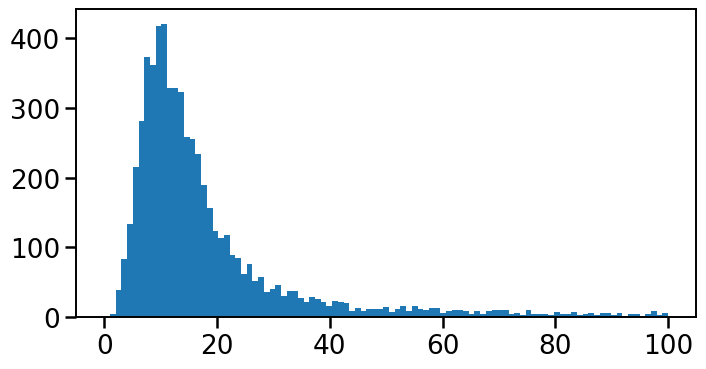

In [5]:
plt.hist(df['Variability_Index'], bins=np.linspace(0,100, 100));

varlim = 80
df_nonvar = df.query(f'Variability_Index <= {varlim}')
df_var    = df.query(f'Variability_Index >= {varlim}')

In [6]:
GLON = [wrap_to_pi(np.deg2rad(d['GLON'])) for d in [df_var, df_nonvar]]
GLAT = [np.deg2rad(d['GLAT']) for d in [df_var, df_nonvar]]

flux = [d['Flux1000'] for d in [df_var, df_nonvar]]

In [7]:
coord = SkyCoord(u.Quantity(df['GLON'], 'deg'),u.Quantity(df['GLAT'], 'deg'),frame='galactic')

In [8]:
# for source_class in source_classes:
#     # We select elements with correct class in upper or lower characters
#     index = np.array([_.strip().lower() == source_class for _ in table['CLASS1']])

#     label = source_class if source_class else 'unid'

#     ax.scatter(
#         coord[index].l.wrap_at(180*u.degree).radian,
#         coord[index].b.radian,
#         label=label,
#     )

NameError: name 'source_classes' is not defined

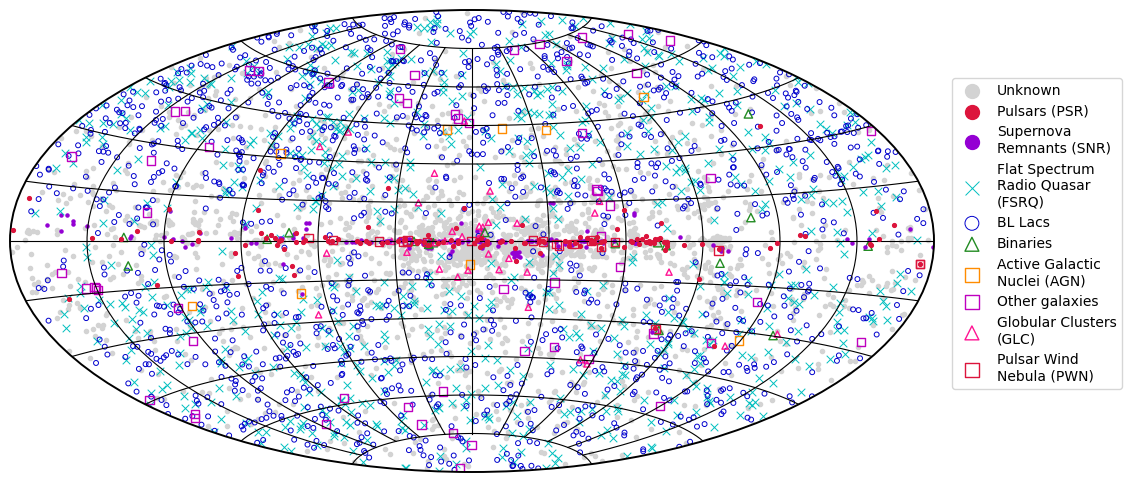

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111, projection='aitoff')

source_classes = ['','psr','spp', 'fsrq', 'bll', 'bin', 'agn', 'gal', 'glc', 'hmb', 'pwn', 'rdg', 'sbg', 'snr']
source_names   = ['','PSR','SNR', 'FSRQ', 'BLL', 'BIN', 'AGN', 'GAL', 'GLC', None, 'PWN',  None,  None,  None]
kws            = [dict(marker='.', color='lightgray', zorder=-100),
                  dict(marker='.', color='crimson', s=30, zorder=10),
                  dict(marker='.', color='darkviolet', s=20),
                  dict(marker='x', color='c', lw=0.7, s=30),
                  dict(marker='.', color='mediumblue', s=50, lw=0.7, facecolor='none'),
                  dict(marker='^', color='forestgreen', facecolor='none'),
                  dict(marker='s', color='darkorange', facecolor='none'),
                  dict(marker='s', color='m', facecolor='none'),
                  dict(marker='^', color='deeppink', s=20, facecolor='none'),
                  dict(marker='^', color='forestgreen', facecolor='none'),
                  dict(marker='s', color='crimson', facecolor='none'),
                 dict(marker='s', color='m', facecolor='none'),
                 dict(marker='s', color='m', facecolor='none'),
                 dict(marker='.', color='darkviolet', s=20)]

for i in range(len(source_classes)):
    # We select elements with correct class in upper or lower characters
    index = np.array([(_.strip().lower() == source_classes[i]) for _ in df['CLASS1']])

    label = source_names[i] if source_classes[i] else 'Unidentified'

    ax.scatter(
        coord[index].l.wrap_at(180*u.degree).radian,
        coord[index].b.radian,
        **kws[i]
    )

source_names   = ['Unknown','Pulsars (PSR)','Supernova\nRemnants (SNR)', 'Flat Spectrum\nRadio Quasar\n(FSRQ)', 'BL Lacs', 'Binaries',
                  'Active Galactic\nNuclei (AGN)', 'Other galaxies', 'Globular Clusters\n(GLC)', None, 'Pulsar Wind\nNebula (PWN)',  None,  None,  None]
kws = [dict(marker='o', color='lightgray',),
       dict(marker='o', color='crimson',),
       dict(marker='o', color='darkviolet'),
       dict(marker='x', color='c', lw=0.7,),
       dict(marker='o', color='mediumblue',lw=0.7, facecolor='none'),
       dict(marker='^', color='forestgreen', facecolor='none'),
       dict(marker='s', color='darkorange', facecolor='none'),
       dict(marker='s', color='m', facecolor='none'),
       dict(marker='^', color='deeppink', facecolor='none'),
       dict(marker='^', color='forestgreen', facecolor='none'),
       dict(marker='s', color='crimson', facecolor='none'),
       dict(marker='s', color='m', facecolor='none'),
       dict(marker='s', color='m', facecolor='none'),
       dict(marker='o', color='darkviolet')]

for lab, k in zip(source_names, kws):
    ax.scatter([], [], **k, label=lab, s=100)
    
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xlabel('lon')
# ax.set_ylabel('lat')
ax.legend(loc=(1.02,.18), fontsize=10)
ax.grid(color='k')
plt.savefig(f'{pltpath}gamma-fermi-catalog-sources{formatIm}', bbox_inches='tight', dpi=dpi)
plt.show()

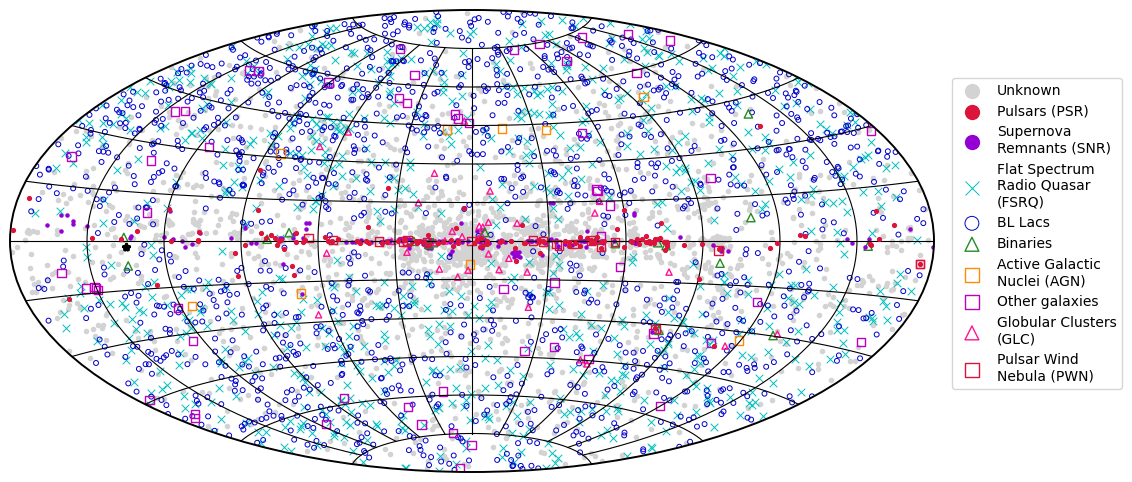

In [18]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111, projection='aitoff')

source_classes = ['','psr','spp', 'fsrq', 'bll', 'bin', 'agn', 'gal', 'glc', 'hmb', 'pwn', 'rdg', 'sbg', 'snr']
source_names   = ['','PSR','SNR', 'FSRQ', 'BLL', 'BIN', 'AGN', 'GAL', 'GLC', None, 'PWN',  None,  None,  None]
kws            = [dict(marker='.', color='lightgray', zorder=-100),
                  dict(marker='.', color='crimson', s=30, zorder=10),
                  dict(marker='.', color='darkviolet', s=20),
                  dict(marker='x', color='c', lw=0.7, s=30),
                  dict(marker='.', color='mediumblue', s=50, lw=0.7, facecolor='none'),
                  dict(marker='^', color='forestgreen', facecolor='none'),
                  dict(marker='s', color='darkorange', facecolor='none'),
                  dict(marker='s', color='m', facecolor='none'),
                  dict(marker='^', color='deeppink', s=20, facecolor='none'),
                  dict(marker='^', color='forestgreen', facecolor='none'),
                  dict(marker='s', color='crimson', facecolor='none'),
                 dict(marker='s', color='m', facecolor='none'),
                 dict(marker='s', color='m', facecolor='none'),
                 dict(marker='.', color='darkviolet', s=20)]

for i in range(len(source_classes)):
    # We select elements with correct class in upper or lower characters
    index = np.array([(_.strip().lower() == source_classes[i]) for _ in df['CLASS1']])

    label = source_names[i] if source_classes[i] else 'Unidentified'

    ax.scatter(
        coord[index].l.wrap_at(180*u.degree).radian,
        coord[index].b.radian,
        **kws[i]
    )

source_names   = ['Unknown','Pulsars (PSR)','Supernova\nRemnants (SNR)', 'Flat Spectrum\nRadio Quasar\n(FSRQ)', 'BL Lacs', 'Binaries',
                  'Active Galactic\nNuclei (AGN)', 'Other galaxies', 'Globular Clusters\n(GLC)', None, 'Pulsar Wind\nNebula (PWN)',  None,  None,  None]
kws = [dict(marker='o', color='lightgray',),
       dict(marker='o', color='crimson',),
       dict(marker='o', color='darkviolet'),
       dict(marker='x', color='c', lw=0.7,),
       dict(marker='o', color='mediumblue',lw=0.7, facecolor='none'),
       dict(marker='^', color='forestgreen', facecolor='none'),
       dict(marker='s', color='darkorange', facecolor='none'),
       dict(marker='s', color='m', facecolor='none'),
       dict(marker='^', color='deeppink', facecolor='none'),
       dict(marker='^', color='forestgreen', facecolor='none'),
       dict(marker='s', color='crimson', facecolor='none'),
       dict(marker='s', color='m', facecolor='none'),
       dict(marker='s', color='m', facecolor='none'),
       dict(marker='o', color='darkviolet')]

for lab, k in zip(source_names, kws):
    ax.scatter([], [], **k, label=lab, s=100)
    
    
ax.plot(-np.pi/4*3, -np.pi/100, '*', color='k')
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xlabel('lon')
# ax.set_ylabel('lat')
ax.legend(loc=(1.02,.18), fontsize=10)
ax.grid(color='k')
# plt.savefig(f'{pltpath}gamma-fermi-catalog-sources-CAS-A{formatIm}', bbox_inches='tight', dpi=dpi)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='aitoff')

ax.scatter(GLON[0], GLAT[0], s=flux[0]*5e8, alpha=0.9)
ax.scatter(GLON[1], GLAT[1], s=flux[1]*5e8, alpha=0.9)


ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.legend()
ax.grid()
plt.show()

In [ ]:
np.unique(df['CLASS1'].to_numpy())

In [ ]:
np.unique(df['CLASS2'].to_numpy())

In [ ]:
df[df['CLASS1'].str.contains('    ')]

In [ ]:
df1 = df[df['CLASS1'].str.contains('BLL|bll')] # BL Lac
df2 = df[df['CLASS1'].str.contains('FSRQ|fsrq|AGN|agn|sey|BCU|bcu|ssqr')|df['CLASS2'].str.contains('agn|sey')]  # AGN
df3 = df[df['CLASS1'].str.contains('SBG|sbg|GAL|gal|RDG|rdg')|df['CLASS2'].str.contains('clust|glc|sbg')] # galaxies
df4 = df[df['CLASS1'].str.contains('MSP|msp|PSR|psr')|df['CLASS2'].str.contains('msp|psr')] #pulsars
df5 = df[df['CLASS1'].str.contains('SNR|snr|spp|PWN')|df['CLASS2'].str.contains('anyof')] # supernova remnant
dff = df[df['CLASS1'].str.contains('any')]

dfs = [df1, df2, df3, df4, df5, dff]

GLON = [wrap_to_pi(np.deg2rad(d['GLON'])) for d in dfs]
GLAT = [np.deg2rad(d['GLAT']) for d in dfs]

flux = [d['Flux1000'] for d in dfs]

fig = plt.figure(figsize=(15, 7))
ax = plt.subplot(111, projection='aitoff')


fff = 1.2e9

ax.scatter(GLON[1], GLAT[1], s=flux[1]*fff, alpha=1, color='b')
ax.scatter(GLON[3], GLAT[3], s=flux[3]*fff, alpha=1, color='c')
ax.scatter(GLON[0], GLAT[0], s=flux[0]*fff, alpha=1, color='k')
# ax.scatter(GLON[2], GLAT[2], s=flux[2]*fff*1.4, alpha=1, color='deeppink')
ax.scatter(GLON[4], GLAT[4], s=flux[4]*fff, alpha=1, color='deeppink')

ax.scatter(GLON[5], GLAT[5], s=20, alpha=1, color='r')



msize = 10
# ax.plot([None], [None], 'o', ms=5, color='deeppink', label='other galaxies')
ax.plot([None], [None], 'o', ms=msize, color='deeppink', label='SN remnants & nebulae')
ax.plot([None], [None], 'o', ms=msize, color='k', label='BL Lac objects')
ax.plot([None], [None], 'o', ms=msize, color='c', label='Pulsars')
ax.plot([None], [None], 'o', ms=msize, color='b', label='AGNs')


ax.legend(loc=1, fontsize=15)
# ax.set_xlabel('$b$  [deg]')
# ax.set_ylabel('$l$  [deg]')

ax.set_xticklabels([])
ax.set_yticklabels([])


# ax.set_facecolor((0,0,0))
ax.tick_params(axis='x', colors='w')
ax.grid(color='k')

plt.savefig(f'{pltpath}gamma-fermi-catalog{formatIm}', bbox_inches='tight', dpi=dpi)
plt.show()